# Clasificación de audio con el Perceptrón Multicapa 

## Dataset
Este conjunto de datos contiene los discursos de estos líderes prominentes; Benjamín Netanyahu, Jens Stoltenberg, Julia Gillard, Margaret
Tacher y Nelson Mandela que también representa los nombres de las carpetas. Cada audio de la carpeta es un PCM de un segundo de duración con una velocidad de muestreo de 16000 hz codificado.
Una carpeta llamada background_noise contiene audios que no son discursos, pero que se pueden encontrar en el interior alrededor del entorno del orador, por ejemplo, la audiencia riendo o aplaudiendo. Se puede mezclar con el discurso mientras se entrena.

### Referencias
https://www.kaggle.com/kongaevans/speaker-recognition-dataset/

## Enunciado

El objetivo del ejercicio consiste en utilizar un perceptrón multicapa para la identificación de la persona que se encuentra hablando a partir de un audio de un segundo de duración.

## Parte I: Introducción al procesamiento de audio

En primera instancia debemos comprender como se representa digitalmente el audio y que características fundamentales tiene.

In [32]:
# Definimos un conjunto de constantes con las rutas de las carpetas que contienen los audios de cada persona
import os

DATASET_ROOT = "sonidos_pajaros"
arundinaceus_DATA = os.path.join(DATASET_ROOT, "Acrocephalus_arundinaceus")
melanopogon_DATA = os.path.join(DATASET_ROOT, "Acrocephalus_melanopogon")
scirpaceus_DATA = os.path.join(DATASET_ROOT, "Acrocephalus_scirpaceus")
atthis_DATA = os.path.join(DATASET_ROOT, "Alcedo_atthis")
platyrhynchos_DATA = os.path.join(DATASET_ROOT, "Anas_platyrhynchos")
strepera_DATA = os.path.join(DATASET_ROOT, "Anas_strepera")
purpurea_DATA = os.path.join(DATASET_ROOT, "Ardea_purpurea")
stellaris_DATA = os.path.join(DATASET_ROOT, "Botaurus_stellaris")
alexandrinus_DATA = os.path.join(DATASET_ROOT, "Charadrius_alexandrinus")
ciconia_DATA = os.path.join(DATASET_ROOT, "Ciconia_ciconia")
aeruginosus_DATA = os.path.join(DATASET_ROOT, "Circus_aeruginosus")
garrulus_DATA = os.path.join(DATASET_ROOT, "Coracias_garrulus")
minor_DATA = os.path.join(DATASET_ROOT, "Dendrocopos_minor")
atra_DATA = os.path.join(DATASET_ROOT, "Fulica_atra")
chloropus_DATA = os.path.join(DATASET_ROOT, "Gallinula_chloropus")
himantopus_DATA = os.path.join(DATASET_ROOT, "Himantopus_himantopus")
minutu_DATA = os.path.join(DATASET_ROOT, "Ixobrychus_minutus")
flava_DATA = os.path.join(DATASET_ROOT, "Motacilla_flava")
porphyrio_DATA = os.path.join(DATASET_ROOT, "Porphyrio_porphyrio")
ruficollis_DATA = os.path.join(DATASET_ROOT, "Tachybaptus_ruficollis")

Para procesar el audio vamos a requerir una librería externa que debemos instalar en el contexto de nuestro Jupyter Notebook, concretamente la librería que vamos a utilizar es librosa: https://librosa.org/doc/latest/index.html

In [160]:
# Escuchamos el fichero de audio que vamos a cargar en el contexto de Jupyter Notebook
import IPython.display as ipd

ipd.Audio(os.path.join(arundinaceus_DATA, "XC417158.mp3"))

In [33]:
# Cargamos el audio mediante la librería librosa
import librosa

wav, sr = librosa.load(os.path.join(arundinaceus_DATA, "XC417158.mp3"))

El método load de librosa nos devuleve dos resultados:
1. Nos devuelve la onda que representa el sonido que estamos cargando en el contexto de nuestro Jupyter Notebook
2. Nos devuelve el ratio de sampleo 

El sonido es una señal analógica, para poder hacerla digital y poderla representar numéricamente tenemos que muestrear la señal original. 

El muestreo consiste en "seleccionar" un número finito de puntos de la señal original y almacenarlos en una matriz. El teorema de muestreo de Nyquist-Shannon mostró que si nuestra tasa de muestreo es lo suficientemente alta, somos capaces de capturar toda la información de la señal e incluso recuperarla completamente.

In [162]:
print(wav)

[-2.3699847e-06  1.2372271e-05 -4.5648108e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]


In [163]:
print(sr)

22050


La tasa de muestreo es muy importante, y la usaremos más adelante en diferentes algoritmos. Generalmente se expresa en hercios (Hz), es decir, el número de puntos (muestras) por segundo. 

En nuestro ejemplo, sr=22050 por lo que tenemos 22050 muestras por segundo, por lo tanto, podemos calcular la longitud del audio de la siguiente forma:

In [164]:
# Con la tasa de muestreo y el tamaño total de la señal se puede calcular la longitud del audio
long_audio = len(wav)/sr
print("La longitud del audio en segundos es:", long_audio)

La longitud del audio en segundos es: 62.07700680272109


Una de las cosas interesantes que debemos hacer para obtener intuiciones sobre nuestra onda de sonido es representarla gráficamente

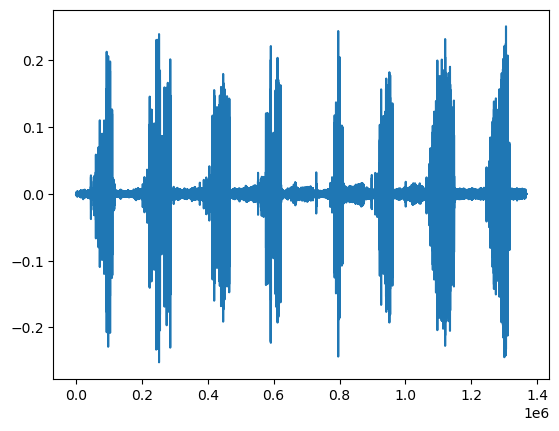

In [165]:
# Representación gráfica de la onda de sonido
from matplotlib import pyplot as plt

plt.plot(wav)
plt.show()

También podemos hacer zoom en determinados puntos específicos seleccionados durante el muestreo

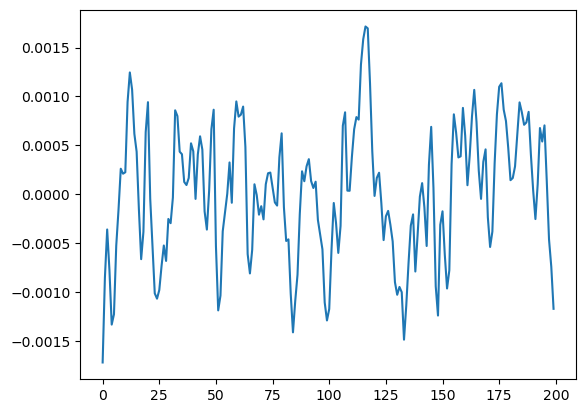

In [166]:
plt.plot(wav[1000:1200])
plt.show()

Hay algo importante que debemos tener en cuenta respecto a lo comentado anteriormente, en realidad, la tasa de muestreo real para el audio que hemos cargado no es 22050 Hz, librosa implícitamente remuestrea nuestros archivos para obtener este valor estándar. Para obtener la tasa de muestreo original, podemos usar el argumento **_sr=False_** en el método **_load_**:

In [167]:
wav, sr = librosa.load(os.path.join(Acrocephalus_DATA, "XC417158.mp3"), sr=None)

In [168]:
print("Tasa de muestreo: {} Hz".format(sr))

Tasa de muestreo: 48000 Hz


El espectrograma nos muestra diferentes frecuencias en diferentes partes de la grabación del sonido. Otra de las propiedades fundamentales es que a nivel de representación son muy similares a una imagen en blanco y negro

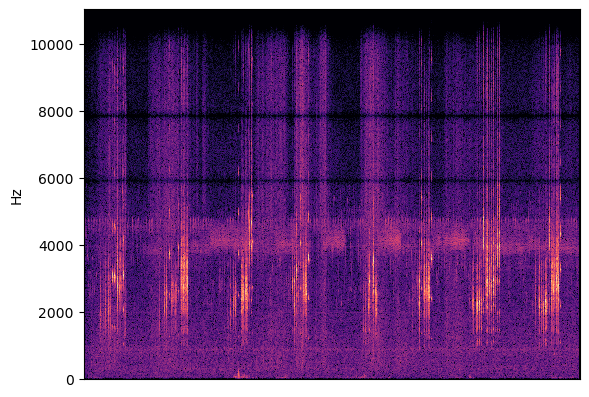

In [34]:
import librosa.display

D = librosa.amplitude_to_db(np.abs(librosa.stft(wav)), ref=np.max)

librosa.display.specshow(D, y_axis='linear')
plt.show()

## 1. Preparación del conjunto de datos

Vamos a comenzar intentando utilizar esta representación del sonido para tratar de identificar el orador al que pertenece la grabación mediante el uso de un Perceptrón Multicapa.

Hay que tener en cuenta que para este tipo de casos prácticos debemos intentar buscar las voces de los oradores emitidas por diferentes altavoces o dispositivos de sonido para que la clasificación no dependa del altavoz que se esta utilizando.

In [113]:
# Definimos una función para parsear nuestro conjunto de datos
def parse_dataset(dataset_paths):
    X = []
    y = []
    for index, dataset in enumerate(dataset_paths):
        print("[+] Parsing {} data...".format(dataset))
        for fname in os.listdir(dataset):
            wav, sr = librosa.load(os.path.join(dataset, fname), sr=None)
            X.append(wav)
            y.append(index)
    return (X, y)

In [114]:
X, y = parse_dataset([arundinaceus_DATA,melanopogon_DATA,scirpaceus_DATA,
                      atthis_DATA,platyrhynchos_DATA,strepera_DATA,purpurea_DATA,stellaris_DATA,
                     alexandrinus_DATA,ciconia_DATA,aeruginosus_DATA,garrulus_DATA,minor_DATA,
                     atra_DATA,chloropus_DATA,himantopus_DATA,minutu_DATA,flava_DATA,
                     porphyrio_DATA,ruficollis_DATA])

[+] Parsing sonidos_pajaros\Acrocephalus_arundinaceus data...
[+] Parsing sonidos_pajaros\Acrocephalus_melanopogon data...
[+] Parsing sonidos_pajaros\Acrocephalus_scirpaceus data...
[+] Parsing sonidos_pajaros\Alcedo_atthis data...
[+] Parsing sonidos_pajaros\Anas_platyrhynchos data...
[+] Parsing sonidos_pajaros\Anas_strepera data...
[+] Parsing sonidos_pajaros\Ardea_purpurea data...
[+] Parsing sonidos_pajaros\Botaurus_stellaris data...
[+] Parsing sonidos_pajaros\Charadrius_alexandrinus data...
[+] Parsing sonidos_pajaros\Ciconia_ciconia data...
[+] Parsing sonidos_pajaros\Circus_aeruginosus data...
[+] Parsing sonidos_pajaros\Coracias_garrulus data...
[+] Parsing sonidos_pajaros\Dendrocopos_minor data...
[+] Parsing sonidos_pajaros\Fulica_atra data...
[+] Parsing sonidos_pajaros\Gallinula_chloropus data...
[+] Parsing sonidos_pajaros\Himantopus_himantopus data...
[+] Parsing sonidos_pajaros\Ixobrychus_minutus data...
[+] Parsing sonidos_pajaros\Motacilla_flava data...
[+] Parsing 

In [115]:
print("La longitud del conjunto de datos es: ", len(X))

La longitud del conjunto de datos es:  879


## 2. División del conjunto de datos

In [116]:
# Dividimos el conjunto de datos en entrenamiento y pruebas
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [117]:
print("Longitud del subconjunto de entrenamiento: ", len(X_train))
print("Longitud del subconjunto de pruebas: ", len(X_test))

Longitud del subconjunto de entrenamiento:  835
Longitud del subconjunto de pruebas:  44


## 3. Construcción del modelo

In [119]:
# Entrenamos un perceptrón multicapa
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(activation='logistic', hidden_layer_sizes=(10,), solver='sgd')
clf.fit(X_train, y_train)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (835,) + inhomogeneous part.

In [89]:
# Realizamos la predicción con el conjunto de datos de prueba
y_pred = clf.predict(X_test)

ValueError: X has 2979695 features, but MLPClassifier is expecting 1115759 features as input.

In [120]:
# Mostramos el f1_score resultante de la clasificación
from sklearn.metrics import f1_score

f1_score(y_test, y_pred, average="binary")

NameError: name 'y_pred' is not defined

In [121]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

NameError: name 'y_pred' is not defined

# Parte II: Otra representación del sonido

Como podemos observar en el ejercicio anterior, si utilizamos las ondas tal cual las estamos leyendo de disco, los resultados de nuestro algoritmo no son demasiado buenos. Por ello, vamos a utilizar otra representación del sonido conocida como espectrogramas.

Antes de comprender lo que es un espectrograma, debemos comprender lo que son las ondas coseno o cosinusoide

In [1]:
# Definimos un conjunto de constantes con las rutas de las carpetas que contienen los audios de cada persona
import os

DATASET_ROOT = "espectro_pajaros"
arundinaceus_DATA = os.path.join(DATASET_ROOT, "Acrocephalus_arundinaceus")
melanopogon_DATA = os.path.join(DATASET_ROOT, "Acrocephalus_melanopogon")
scirpaceus_DATA = os.path.join(DATASET_ROOT, "Acrocephalus_scirpaceus")
atthis_DATA = os.path.join(DATASET_ROOT, "Alcedo_atthis")
platyrhynchos_DATA = os.path.join(DATASET_ROOT, "Anas_platyrhynchos")
strepera_DATA = os.path.join(DATASET_ROOT, "Anas_strepera")
purpurea_DATA = os.path.join(DATASET_ROOT, "Ardea_purpurea")
stellaris_DATA = os.path.join(DATASET_ROOT, "Botaurus_stellaris")
alexandrinus_DATA = os.path.join(DATASET_ROOT, "Charadrius_alexandrinus")
ciconia_DATA = os.path.join(DATASET_ROOT, "Ciconia_ciconia")
aeruginosus_DATA = os.path.join(DATASET_ROOT, "Circus_aeruginosus")
garrulus_DATA = os.path.join(DATASET_ROOT, "Coracias_garrulus")
minor_DATA = os.path.join(DATASET_ROOT, "Dendrocopos_minor")
atra_DATA = os.path.join(DATASET_ROOT, "Fulica_atra")
chloropus_DATA = os.path.join(DATASET_ROOT, "Gallinula_chloropus")
himantopus_DATA = os.path.join(DATASET_ROOT, "Himantopus_himantopus")
minutu_DATA = os.path.join(DATASET_ROOT, "Ixobrychus_minutus")
flava_DATA = os.path.join(DATASET_ROOT, "Motacilla_flava")
porphyrio_DATA = os.path.join(DATASET_ROOT, "Porphyrio_porphyrio")
ruficollis_DATA = os.path.join(DATASET_ROOT, "Tachybaptus_ruficollis")

- Dimensiones de la imagen:
(224, 224)


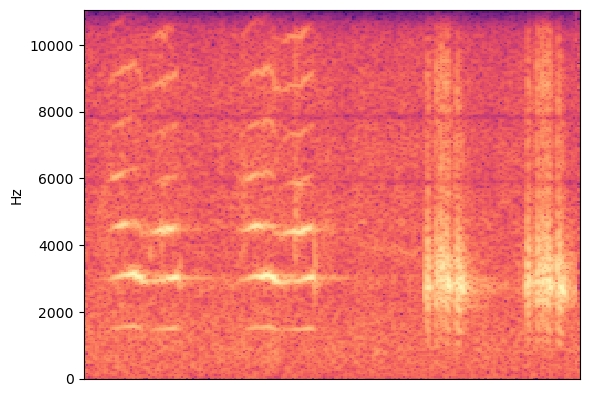

In [37]:
import numpy as np


#asa= np.load("espectro_pajaros/Acrocephalus_arundinaceus/XC417158_0.npy")/255.0 # imread lee las imagenes con los pixeles codificados como enteros 
# en el rango 0-255. Por eso la convertimos a flotante y en el rango 0-1
asa= np.load(os.path.join(arundinaceus_DATA, "XC417158_0.npy"))
print("- Dimensiones de la imagen:")
print(asa.shape)

librosa.display.specshow(asa, y_axis='linear')
plt.show()


## 1. Preparación del conjunto de datos

In [4]:
# Definimos una función para parsear nuestro conjunto de datos
import librosa
import numpy as np
def parse_dataset(dataset_paths):
    X = []
    y = []
    for index, dataset in enumerate(dataset_paths):
        print("[+] Parsing {} data...".format(dataset))
        for fname in os.listdir(dataset):
            D = np.load(os.path.join(dataset, fname))
            X.append(D)
            y.append(index)
    return (X, y)

In [5]:
# X_prep, y_prep = parse_dataset([BENJAMIN_DATA, JENS_DATA])
X_prep, y_prep = parse_dataset([arundinaceus_DATA,melanopogon_DATA,scirpaceus_DATA,
                      atthis_DATA,platyrhynchos_DATA,strepera_DATA,purpurea_DATA,stellaris_DATA,
                     alexandrinus_DATA,ciconia_DATA,aeruginosus_DATA,garrulus_DATA,minor_DATA,
                     atra_DATA,chloropus_DATA,himantopus_DATA,minutu_DATA,flava_DATA,
                     porphyrio_DATA,ruficollis_DATA])

[+] Parsing espectro_pajaros\Acrocephalus_arundinaceus data...
[+] Parsing espectro_pajaros\Acrocephalus_melanopogon data...
[+] Parsing espectro_pajaros\Acrocephalus_scirpaceus data...
[+] Parsing espectro_pajaros\Alcedo_atthis data...
[+] Parsing espectro_pajaros\Anas_platyrhynchos data...
[+] Parsing espectro_pajaros\Anas_strepera data...
[+] Parsing espectro_pajaros\Ardea_purpurea data...
[+] Parsing espectro_pajaros\Botaurus_stellaris data...
[+] Parsing espectro_pajaros\Charadrius_alexandrinus data...
[+] Parsing espectro_pajaros\Ciconia_ciconia data...
[+] Parsing espectro_pajaros\Circus_aeruginosus data...
[+] Parsing espectro_pajaros\Coracias_garrulus data...
[+] Parsing espectro_pajaros\Dendrocopos_minor data...
[+] Parsing espectro_pajaros\Fulica_atra data...
[+] Parsing espectro_pajaros\Gallinula_chloropus data...
[+] Parsing espectro_pajaros\Himantopus_himantopus data...
[+] Parsing espectro_pajaros\Ixobrychus_minutus data...
[+] Parsing espectro_pajaros\Motacilla_flava da

In [6]:
X_prep[100].max()

0.0

## 2. División del conjunto de datos

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_prep, y_prep, test_size=0.05)

In [8]:
print(len(X_train))
print(len(X_test))

16535
871


## 3. Construcción del modelo

Preprocesamos los subconjuntos de datos para que puedan ser posteriormente procesados por la red neuronal artificial

In [9]:
X_train_prep = np.array(X_train).reshape((len(X_train), 224*224))
X_train_prep = np.array(X_train_prep).astype('float32') / 255
y_train_prep = np.array(y_train)

X_test_prep = np.array(X_test).reshape((len(X_test), 224*224))
X_test_prep = np.array(X_test_prep).astype('float32') / 255
y_test_prep = np.array(y_test)

In [10]:
X_train_prep[0]

array([-0.1142398 , -0.11679283, -0.28416395, ..., -0.28162298,
       -0.3137255 , -0.25452706], dtype=float32)

In [154]:
# Entrenamos un perceptrón multicapa
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(activation='logistic', hidden_layer_sizes=(20,), solver='sgd')
clf.fit(X_train_prep, y_train_prep)

D:\Users\firef\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', hidden_layer_sizes=(20,), solver='sgd')

In [155]:
# Realizamos la predicción con el conjunto de datos de prueba
y_pred = clf.predict(X_test_prep)

In [156]:
# Mostramos el f1_score resultante de la clasificación
from sklearn.metrics import f1_score

# f1_score(y_test, y_pred, average="binary")
f1_score(y_test, y_pred, average="weighted")

0.4556346352957076

## Opcion 2 ML

In [11]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.utils import resample

In [12]:
# Build the Random Forest model
model = RandomForestClassifier()
model.fit(X_train_prep, y_train_prep)

RandomForestClassifier()

In [13]:
# Predict the classes of the test data using the model
y_pred = model.predict(X_test_prep)


In [14]:
# Calculate the accuracy of the model
accuracy = np.mean(y_pred == y_test_prep)
print("Model Accuracy:", accuracy)

Model Accuracy: 0.7141216991963261


## Árboles de decisión II - Ensemble
- - -

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings(action="ignore")

In [48]:
# Definimos una función para parsear nuestro conjunto de datos
import librosa
import numpy as np

def parse_dataset(dataset_paths):
    X = []
    y = []
    for index, dataset in enumerate(dataset_paths):
        print("[+] Parsing {} data...".format(dataset))
        for fname in os.listdir(dataset):
            D = np.load(os.path.join(dataset, fname))
            X.append(D)
            y.append(index)
    return (X, y)

In [49]:
X, y = parse_dataset([arundinaceus_DATA,melanopogon_DATA,scirpaceus_DATA,
                      atthis_DATA,platyrhynchos_DATA,strepera_DATA,purpurea_DATA,stellaris_DATA,
                     alexandrinus_DATA,ciconia_DATA,aeruginosus_DATA,garrulus_DATA,minor_DATA,
                     atra_DATA,chloropus_DATA,himantopus_DATA,minutu_DATA,flava_DATA,
                     porphyrio_DATA,ruficollis_DATA])

[+] Parsing espectro_pajaros\Acrocephalus_arundinaceus data...
[+] Parsing espectro_pajaros\Acrocephalus_melanopogon data...
[+] Parsing espectro_pajaros\Acrocephalus_scirpaceus data...
[+] Parsing espectro_pajaros\Alcedo_atthis data...
[+] Parsing espectro_pajaros\Anas_platyrhynchos data...
[+] Parsing espectro_pajaros\Anas_strepera data...
[+] Parsing espectro_pajaros\Ardea_purpurea data...
[+] Parsing espectro_pajaros\Botaurus_stellaris data...
[+] Parsing espectro_pajaros\Charadrius_alexandrinus data...
[+] Parsing espectro_pajaros\Ciconia_ciconia data...
[+] Parsing espectro_pajaros\Circus_aeruginosus data...
[+] Parsing espectro_pajaros\Coracias_garrulus data...
[+] Parsing espectro_pajaros\Dendrocopos_minor data...
[+] Parsing espectro_pajaros\Fulica_atra data...
[+] Parsing espectro_pajaros\Gallinula_chloropus data...
[+] Parsing espectro_pajaros\Himantopus_himantopus data...
[+] Parsing espectro_pajaros\Ixobrychus_minutus data...
[+] Parsing espectro_pajaros\Motacilla_flava da

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_prep, y_prep, test_size=0.05, random_state=1, stratify=y)

In [52]:
print(len(X_train))
print(len(X_test))

16535
871


In [53]:
X_train_prep = np.array(X_train).reshape((len(X_train), 224*224))
X_train_prep = np.array(X_train_prep).astype('float32') / 255
y_train_prep = np.array(y_train)

X_test_prep = np.array(X_test).reshape((len(X_test), 224*224))
X_test_prep = np.array(X_test_prep).astype('float32') / 255
y_test_prep = np.array(y_test)

In [54]:
print(len(X_train_prep))
print(len(X_test_prep))

16535
871


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_prep, y_prep, test_size=0.05)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_prep, y_test_prep, stratify=y, test_size=0.30, random_state=1)

In [55]:
DTC = DecisionTreeClassifier(random_state=1,max_depth=3)

In [56]:
DTC.fit(X_train_prep, y_train_prep)

DecisionTreeClassifier(max_depth=3, random_state=1)

In [57]:
print("AUC - Datos de validation")
cross_val_score(DTC, X_train_prep, y_train_prep, cv=10, scoring="roc_auc").mean()

AUC - Datos de validation


nan

# opciopn 2 esemble

In [59]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [60]:
# Definimos una función para parsear nuestro conjunto de datos
import librosa
import numpy as np

def parse_dataset(dataset_paths):
    X = []
    y = []
    for index, dataset in enumerate(dataset_paths):
        print("[+] Parsing {} data...".format(dataset))
        for fname in os.listdir(dataset):
            D = np.load(os.path.join(dataset, fname))
            X.append(D)
            y.append(index)
    return (X, y)

In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_prep, y_prep, test_size=0.05)

In [62]:
X_train_prep = np.array(X_train).reshape((len(X_train), 224*224))
X_train_prep = np.array(X_train_prep).astype('float32') / 255
y_train_prep = np.array(y_train)

X_test_prep = np.array(X_test).reshape((len(X_test), 224*224))
X_test_prep = np.array(X_test_prep).astype('float32') / 255
y_test_prep = np.array(y_test)

In [63]:
# Create a list of classifiers
classifiers = [
    RandomForestClassifier(n_estimators=100),
    GradientBoostingClassifier(),
    DecisionTreeClassifier(),
    KNeighborsClassifier(n_neighbors=5)
]

In [ ]:
# Loop over each classifier and fit it to the training data
for classifier in classifiers:
    classifier.fit(X_train_prep, y_train_prep)

In [ ]:
# Loop over each classifier and calculate its accuracy on the test data
for classifier in classifiers:
    accuracy = classifier.score(X_test_prep, y_test_prep)
    print(type(classifier).__name__, "Accuracy:", accuracy)

# Clasificación de sonido con Keras

In [27]:
# Definimos un conjunto de constantes con las rutas de las carpetas que contienen los audios de cada persona
import os

DATASET_ROOT = "espectro_pajaros"
arundinaceus_DATA = os.path.join(DATASET_ROOT, "Acrocephalus_arundinaceus")
melanopogon_DATA = os.path.join(DATASET_ROOT, "Acrocephalus_melanopogon")
scirpaceus_DATA = os.path.join(DATASET_ROOT, "Acrocephalus_scirpaceus")
atthis_DATA = os.path.join(DATASET_ROOT, "Alcedo_atthis")
platyrhynchos_DATA = os.path.join(DATASET_ROOT, "Anas_platyrhynchos")
strepera_DATA = os.path.join(DATASET_ROOT, "Anas_strepera")
purpurea_DATA = os.path.join(DATASET_ROOT, "Ardea_purpurea")
stellaris_DATA = os.path.join(DATASET_ROOT, "Botaurus_stellaris")
alexandrinus_DATA = os.path.join(DATASET_ROOT, "Charadrius_alexandrinus")
ciconia_DATA = os.path.join(DATASET_ROOT, "Ciconia_ciconia")
aeruginosus_DATA = os.path.join(DATASET_ROOT, "Circus_aeruginosus")
garrulus_DATA = os.path.join(DATASET_ROOT, "Coracias_garrulus")
minor_DATA = os.path.join(DATASET_ROOT, "Dendrocopos_minor")
atra_DATA = os.path.join(DATASET_ROOT, "Fulica_atra")
chloropus_DATA = os.path.join(DATASET_ROOT, "Gallinula_chloropus")
himantopus_DATA = os.path.join(DATASET_ROOT, "Himantopus_himantopus")
minutu_DATA = os.path.join(DATASET_ROOT, "Ixobrychus_minutus")
flava_DATA = os.path.join(DATASET_ROOT, "Motacilla_flava")
porphyrio_DATA = os.path.join(DATASET_ROOT, "Porphyrio_porphyrio")
ruficollis_DATA = os.path.join(DATASET_ROOT, "Tachybaptus_ruficollis")

## 1. Preparación del conjunto de datos

In [28]:
# Definimos una función para parsear nuestro conjunto de datos
import librosa
import numpy as np

def parse_dataset(dataset_paths):
    X = []
    y = []
    for index, dataset in enumerate(dataset_paths):
        print("[+] Parsing {} data...".format(dataset))
        for fname in os.listdir(dataset):
            D = np.load(os.path.join(dataset, fname))
            X.append(D)
            y.append(index)
    return (X, y)

In [29]:
X, y = parse_dataset([arundinaceus_DATA,melanopogon_DATA,scirpaceus_DATA,
                      atthis_DATA,platyrhynchos_DATA,strepera_DATA,purpurea_DATA,stellaris_DATA,
                     alexandrinus_DATA,ciconia_DATA,aeruginosus_DATA,garrulus_DATA,minor_DATA,
                     atra_DATA,chloropus_DATA,himantopus_DATA,minutu_DATA,flava_DATA,
                     porphyrio_DATA,ruficollis_DATA])

[+] Parsing espectro_pajaros\Acrocephalus_arundinaceus data...
[+] Parsing espectro_pajaros\Acrocephalus_melanopogon data...
[+] Parsing espectro_pajaros\Acrocephalus_scirpaceus data...
[+] Parsing espectro_pajaros\Alcedo_atthis data...
[+] Parsing espectro_pajaros\Anas_platyrhynchos data...
[+] Parsing espectro_pajaros\Anas_strepera data...
[+] Parsing espectro_pajaros\Ardea_purpurea data...
[+] Parsing espectro_pajaros\Botaurus_stellaris data...
[+] Parsing espectro_pajaros\Charadrius_alexandrinus data...
[+] Parsing espectro_pajaros\Ciconia_ciconia data...
[+] Parsing espectro_pajaros\Circus_aeruginosus data...
[+] Parsing espectro_pajaros\Coracias_garrulus data...
[+] Parsing espectro_pajaros\Dendrocopos_minor data...
[+] Parsing espectro_pajaros\Fulica_atra data...
[+] Parsing espectro_pajaros\Gallinula_chloropus data...
[+] Parsing espectro_pajaros\Himantopus_himantopus data...
[+] Parsing espectro_pajaros\Ixobrychus_minutus data...
[+] Parsing espectro_pajaros\Motacilla_flava da

## 2. División del conjunto de datos

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [6]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [7]:
print("Longitud subconjunto de entrenamiento: ", len(X_train))
print("Longitud subconjunto de validación: ", len(X_val))
print("Longitud subconjunto de pruebas: ", len(X_test))

Longitud subconjunto de entrenamiento:  15665
Longitud subconjunto de validación:  871
Longitud subconjunto de pruebas:  870


## 3. Construcción del modelo

In [8]:
from tensorflow.keras.utils import to_categorical

def prep_dataset(X, y, shape):
    X_prep = np.array(X).reshape((len(X), shape))
    X_prep = X_prep.astype('float32') / 255
    y_prep = to_categorical(np.array(y))
    return (X_prep, y_prep)

In [10]:
X_train_prep, y_train_prep = prep_dataset(X_train, y_train, 224*224)
X_val_prep, y_val_prep = prep_dataset(X_val, y_val, 224*224)
X_test_prep, y_test_prep = prep_dataset(X_test, y_test, 224*224)

In [11]:
X_train_prep

array([[-0.07256848, -0.07912534, -0.11329869, ..., -0.14831248,
        -0.11839274, -0.09970248],
       [-0.12023573, -0.15224855, -0.10869984, ..., -0.18263672,
        -0.15331472, -0.09223871],
       [-0.12479589, -0.13621137, -0.19065699, ..., -0.18272147,
        -0.15265915, -0.16202681],
       ...,
       [-0.1102713 , -0.12429756, -0.11874359, ..., -0.17806636,
        -0.15077949, -0.14520225],
       [-0.1544944 , -0.16367596, -0.20272382, ..., -0.23002432,
        -0.20356303, -0.1108859 ],
       [-0.11633623, -0.12549946, -0.1817636 , ..., -0.13338138,
        -0.1035306 , -0.12019949]], dtype=float32)

In [12]:
y_train_prep

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

### 3.1. Entrenamiento de una RNA sencilla

In [13]:
# Entrenamos un perceptrón multicapa
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(activation='logistic', hidden_layer_sizes=(10,), solver='sgd')
clf.fit(X_train_prep, y_train)

D:\Users\firef\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', hidden_layer_sizes=(10,), solver='sgd')

In [14]:
# Realizamos la predicción con el conjunto de datos de validación
y_pred = clf.predict(X_val_prep)

In [15]:
# Mostramos el accuracy resultante de la clasificación
from sklearn.metrics import accuracy_score

accuracy_score(y_val, y_pred)

0.41676234213547647

### 3.2. Entrenamiento de una RNA profunda

In [22]:
from tensorflow.keras import models
from tensorflow.keras import layers

In [23]:
network = models.Sequential()

network.add(layers.Dense(600, activation='relu', input_shape=(224*224,)))
network.add(layers.Dense(400, activation='relu'))
network.add(layers.Dense(200, activation='relu'))
network.add(layers.Dense(20, activation='softmax'))

In [24]:
network.compile(loss='categorical_crossentropy',
                optimizer='sgd',
                metrics=['accuracy', 'Precision'])

In [25]:
history = network.fit(X_train_prep, 
                      y_train_prep,
                      epochs=60,
                      validation_data=(X_val_prep, y_val_prep))

Epoch 1/60
490/490 [==============================] - 29s 58ms/step - loss: 2.3709 - accuracy: 0.2476 - precision: 0.5798 - val_loss: 2.1445 - val_accuracy: 0.2526 - val_precision: 0.6863
Epoch 2/60
490/490 [==============================] - 27s 54ms/step - loss: 1.8793 - accuracy: 0.3779 - precision: 0.6741 - val_loss: 1.6894 - val_accuracy: 0.4420 - val_precision: 0.6850
Epoch 3/60
490/490 [==============================] - 31s 63ms/step - loss: 1.6649 - accuracy: 0.4459 - precision: 0.6683 - val_loss: 1.5371 - val_accuracy: 0.5144 - val_precision: 0.7076
Epoch 4/60
490/490 [==============================] - 30s 60ms/step - loss: 1.5468 - accuracy: 0.4849 - precision: 0.6922 - val_loss: 1.7227 - val_accuracy: 0.4294 - val_precision: 0.5828
Epoch 5/60
490/490 [==============================] - 33s 68ms/step - loss: 1.4515 - accuracy: 0.5196 - precision: 0.7140 - val_loss: 1.5299 - val_accuracy: 0.4811 - val_precision: 0.7075
Epoch 6/60
490/490 [==============================] - 32s 65

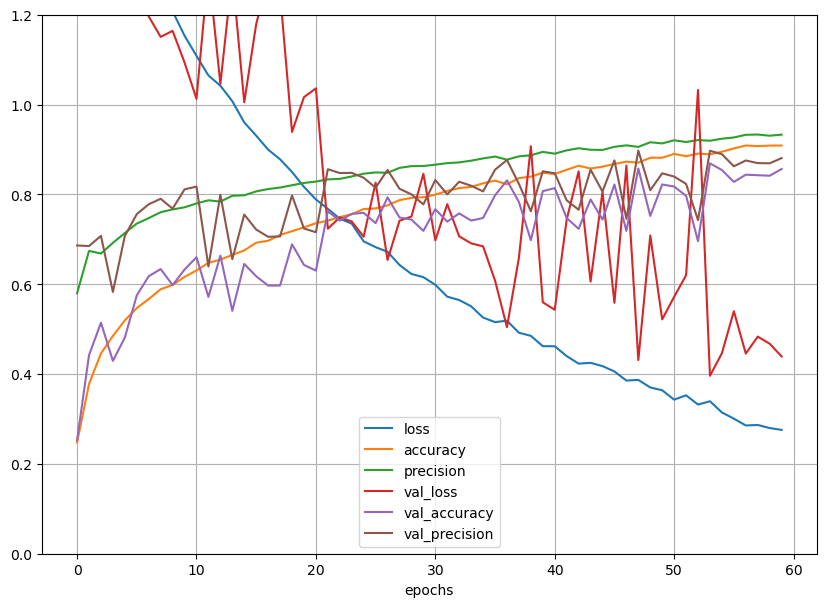

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1.2)
plt.xlabel("epochs")
plt.show()

### 3.3. Predicción para nuevos ejemplos

In [28]:
# Realizamos la predicción para el subconjunto de pruebas
test_loss, test_acc, test_prec = network.evaluate(X_test_prep, y_test_prep)

28/28 [==============================] - 0s 14ms/step - loss: 0.4906 - accuracy: 0.8483 - precision: 0.8831


In [29]:
print('test_acc:', test_acc)
print('test_prec:', test_prec)

test_acc: 0.8482758402824402
test_prec: 0.8830845952033997


# opcion 2 DM

In [31]:
import numpy as np
import pandas as pd

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_prep, y_prep, test_size=0.05)

In [33]:
X_train_prep = np.array(X_train).reshape((len(X_train), 224*224))
X_train_prep = np.array(X_train_prep).astype('float32') / 255
y_train_prep = np.array(y_train)
y2 = to_categorical(y_train_prep)

X_test_prep = np.array(X_test).reshape((len(X_test), 224*224))
X_test_prep = np.array(X_test_prep).astype('float32') / 255
y_test_prep = np.array(y_test)

In [ ]:
# Preprocess the data
X = X.reshape(-1, 128, 128, 1) # Reshape the data into a 3-dimensional array
y = to_categorical(y) # One-hot encode the target variable


In [37]:
y2 = to_categorical(y_train_prep)

In [38]:
# Build the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(y2.shape[10], activation='softmax'))

IndexError: tuple index out of range

In [ ]:

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [ ]:
# Train the model
model.fit(X_train_prep, y_train_prep, epochs=10, batch_size=32, validation_data=(X_test_prep, y_test_prep))

In [ ]:
# Evaluate the model on the test data
_, accuracy = model.evaluate(X_test_prep, y_test_prep)
print("Model Accuracy:", accuracy)
